In [0]:
import numpy as np
import pandas as pd

url = "https://drive.google.com/uc?export=download&id=1bqUedFHB8YVzrXbmPZ_unGwOUaCMVje6"
df = pd.read_excel(url, header=0)
print('Columns:', list(df))
dataset = df.values

# Discard non-"Q" features, select pop. estimate as response
X = dataset[:, 1:14]
y = dataset[:, -1]

Columns: ['Month', 'Q0', 'Q1', 'Q2pt5', 'Q5', 'Q10', 'Q25', 'Q50', 'Q75', 'Q90', 'Q95', 'Q97pt5', 'Q99', 'Q100', 'STNAME', 'CTYNAME', 'POPESTIMATE2015']


## k-fold cross-validation

In [0]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

np.random.seed(123)

models = [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor()]

# Set up the whole range of indices in the dataset, and split it into ten
np.random.shuffle(dataset)
index = np.arange(len(dataset))
splits = np.split(index, 10)

# k-fold cross-validation
fold = 1
for i, split in enumerate(splits):
  print("Fold:", fold); fold += 1
  
  # Generate test and train indices, similar to sklearn's method
  test_index = split
  train_index = np.concatenate(splits[:i] + splits[i+1:], axis=0)
  
  # Split into X and y
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  # Train each model
  for model in models:
    model.fit(X_train, y_train)
    df.loc[train_index, (str(model)+'Train')] = model.predict(X_train)
    df.loc[test_index, (str(model)+'Test')] = model.predict(X_test)

Fold: 1


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10


## Error table

In [0]:
def absolute_percentage_error(y_true, y_pred):
  return np.abs((y_true - y_pred)/y_true) * 100

y_true = df["POPESTIMATE2015"].values
error_arr = []

# Collect error metrics for each model
for model in models:
  train_mape = np.mean(absolute_percentage_error(y_true, df[str(model)+'Train'].values))
  train_ape_sd = np.std(absolute_percentage_error(y_true, df[str(model)+'Train'].values))
  train_mae = mean_absolute_error(y_true, df[str(model)+'Train'].values)
  train_ae_sd = np.std(np.abs(y_true - df[str(model)+'Train'].values))
  
  test_mape = np.mean(absolute_percentage_error(y_true, df[str(model)+'Test'].values))
  test_ape_sd = np.std(absolute_percentage_error(y_true, df[str(model)+'Test'].values))
  test_mae = mean_absolute_error(y_true, df[str(model)+'Test'].values)
  test_ae_sd = np.std(np.abs(y_true - df[str(model)+'Test'].values))
  
  error_arr.append([train_mape, train_ape_sd, train_mae, train_ae_sd,
                    test_mape, test_ape_sd, test_mae, test_ae_sd])
  
# Create table
error_df = pd.DataFrame(error_arr, columns = ['Train MAPE', '(sd)', 'Test MAPE', '(sd)', 'Train MAE', '(sd)', 'Test MAE', '(sd)'])
error_df.rename(index={0:'Linear Regression', 1:'Random Forest', 2:'Gradient Boosting Model'}, inplace=True)
display(error_df)

,Train MAPE,(sd),Test MAPE,(sd),Train MAE,(sd),Test MAE,(sd)
Linear Regression,1015.327952,4495.782905,139066.670670,367162.715563,1040.922029,4778.677622,140043.848935,371470.127637
Random Forest,996.710762,4687.543267,143314.262695,392482.071296,1073.151975,5209.842781,144616.177017,379491.543812
Gradient Boosting Model,981.934070,4641.545955,140983.241635,423453.796161,1023.308891,4821.661081,141002.486424,374576.843809


## Box plots

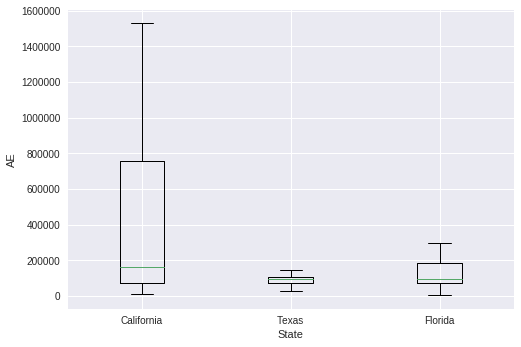

In [0]:
import matplotlib.pyplot as plt

# Calculate the mean test prediction between all three models
df['mean_test_pred'] = np.mean([df[str(model)+'Test'].values for model in models])

states = ['California', 'Texas', 'Florida']

# Generate AE and APE vectors for each state
state_ae_arr = []
state_ape_arr = []
for state in states:
  df_state = df[df['STNAME'] == state]
  y_true = df_state['POPESTIMATE2015'].values
  y_pred = df_state['mean_test_pred'].values
  
  state_ae_arr.append(np.abs(y_true - y_pred))
  state_ape_arr.append(absolute_percentage_error(y_true, y_pred))

# Box plot for AE (no outliers)
fig, ax = plt.subplots()
ax.boxplot(state_ae_arr, showfliers=False)
ax.set_xlabel('State')
ax.set_ylabel('AE')
ax.set_xticklabels(states)

plt.show()

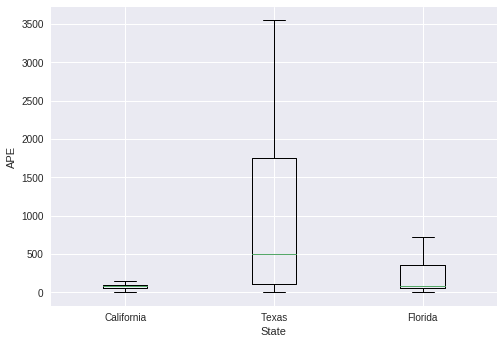

In [0]:
# Box plot for APE (no outliers)
fig, ax = plt.subplots()
ax.boxplot(state_ape_arr, showfliers=False)
ax.set_xlabel('State')
ax.set_ylabel('APE')
ax.set_xticklabels(states)

plt.show()

## Worst counties

In [0]:
# Find the MAE of the mean prediction for each county
county_maes = {}
for county in set(df['CTYNAME']):
  df_county = df[df['CTYNAME'] == county]
  county_maes[county] = mean_absolute_error(df_county['POPESTIMATE2015'], df_county['mean_test_pred'].values)

sorted(county_maes, key=county_maes.get, reverse=True)[:50]

['Los Angeles',
 'Maricopa',
 'San Diego',
 'Miami-Dade',
 'Harris',
 'Riverside',
 'Queens',
 'San Bernardino',
 'Tarrant',
 'Santa Clara',
 'Bexar',
 'Cook',
 'New York',
 'Alameda',
 'Sacramento',
 'Bronx',
 'Kings',
 'Hillsborough',
 'Cuyahoga',
 'Oakland',
 'Hennepin',
 'King',
 'Fairfax',
 'Suffolk',
 'Contra Costa',
 'Wake',
 'Pima',
 'St. Louis',
 'Honolulu',
 'Westchester',
 'Fresno',
 'Milwaukee',
 'Pinellas',
 'Bergen',
 'DuPage',
 'Collin',
 "Prince George's",
 'Gwinnett',
 'Kern',
 'San Francisco',
 'Macomb',
 'New Haven',
 'Orange',
 'Oklahoma',
 'Snohomish',
 'San Mateo',
 'El Paso',
 'Cobb',
 'San Joaquin',
 'Fort Bend']